<div style="text-align: center;">
    <span style="background-color: darkblue; color: cyan; padding: 10px; font-size: 24px; text-shadow: 2px 2px yellow;">TEAM AVON-MAET PREDICTIVE ANALYTICS SOLUTION</span>
</div>

# Importing Libraries ;

In [285]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import sklearn
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import warnings



warnings.filterwarnings('ignore')

# Loading Files from Disk

In [18]:
pest = pd.read_csv("PEST.csv")
pest_type = pd.read_csv("PEST_TYPE.csv")
weather = pd.read_csv("WEATHER.csv")
weather_condition = pd.read_csv("WEATHER_CONDITION.csv")

C:\Users\HP\AppData\Local\Temp\ipykernel_18036\949955763.py:3: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("WEATHER.csv")


# Data Preprocessing

In [19]:
for table in [pest,pest_type, weather, weather_condition]:
    print("================================")
    print(table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097138 entries, 0 to 2097137
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   TIMESTAMP         object
 1   PEST_SEVERITY     object
 2   PEST_DESCRIPTION  object
 3   PEST_ID           object
dtypes: object(4)
memory usage: 64.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PEST_ID    8 non-null      object
 1   PEST_TYPE  8 non-null      object
dtypes: object(2)
memory usage: 256.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2608640 entries, 0 to 2608639
Data columns (total 4 columns):
 #   Column                Dtype  
---  ------                -----  
 0   TIMESTAMP             object 
 1   WIND_SPEED_MS         float64
 2   PRECIPITATION_M       float64
 3   WEATHER_CONDITION_ID  object 
dtypes: float64(2), object(2)
memo

In [20]:
pest.head()

,TIMESTAMP,PEST_SEVERITY,PEST_DESCRIPTION,PEST_ID
0,2023-02-13T04:49:00Z,Low,NaN,P1
1,2023-01-16T19:21:00Z,High,NaN,P1
2,2023-01-17T15:18:00Z,Medium,NaN,P8
3,2022-11-29T13:54:00Z,High,NaN,P8
4,2022-10-14T10:18:00Z,Medium,NaN,P1


In [23]:
pest_type

,PEST_ID,PEST_TYPE
0,P5,No Pest Issue
1,P6,Other
2,P3,Fungus
3,P4,Mites
4,P7,Slugs
5,P8,Whiteflies
6,P1,Aphids
7,P2,Caterpillars


In [24]:
# creating a mapper object to populate the PEST table
pest_mapper = dict(zip(pest_type['PEST_ID'], pest_type['PEST_TYPE']))

In [25]:
pest['PEST_TYPE'] = pest['PEST_ID'].map(pest_mapper)

In [26]:
pest

,TIMESTAMP,PEST_SEVERITY,PEST_DESCRIPTION,PEST_ID,PEST_TYPE
0,2023-02-13T04:49:00Z,Low,NaN,P1,Aphids
1,2023-01-16T19:21:00Z,High,NaN,P1,Aphids
2,2023-01-17T15:18:00Z,Medium,NaN,P8,Whiteflies
3,2022-11-29T13:54:00Z,High,NaN,P8,Whiteflies
4,2022-10-14T10:18:00Z,Medium,NaN,P1,Aphids
...,...,...,...,...,...
2097133,2022-09-25T08:32:00Z,NaN,Slugs : infestation found.,P7,Slugs
2097134,2023-03-02T00:58:00Z,High,Other : presence detected.,P6,Other
2097135,2023-04-07T23:57:00Z,High,Other : infestation detected.,P6,Other
2097136,2023-03-03T12:01:00Z,Low,Other : presence detected.,P6,Other


In [28]:
pest.columns

Index(['TIMESTAMP', 'PEST_SEVERITY', 'PEST_DESCRIPTION', 'PEST_ID',
       'PEST_TYPE'],
      dtype='object')

In [31]:
# converting columns to lowercase

for table in [pest,pest_type, weather, weather_condition]:
    table.columns = [col.lower() for col in table.columns]

In [32]:
pest.head()

,timestamp,pest_severity,pest_description,pest_id,pest_type
0,2023-02-13T04:49:00Z,Low,NaN,P1,Aphids
1,2023-01-16T19:21:00Z,High,NaN,P1,Aphids
2,2023-01-17T15:18:00Z,Medium,NaN,P8,Whiteflies
3,2022-11-29T13:54:00Z,High,NaN,P8,Whiteflies
4,2022-10-14T10:18:00Z,Medium,NaN,P1,Aphids


In [34]:
weather['weather_condition_id'].value_counts()

WC-8    210407
WC-2    210034
WC-4    209914
WC-3    209504
WC-7    209156
WC-6    208843
WC-5    189413
WC-1    188507
Name: weather_condition_id, dtype: int64

In [35]:
weather_condition

,weather_condition_id,weather_condition
0,WC-5,Partly Cloudy
1,WC-6,Rain
2,WC-7,Snow
3,WC-8,Thunderstorm
4,WC-3,Fog
5,WC-4,Mist
6,WC-1,Clear
7,WC-2,Cloudy


In [36]:
# creating a weather mapper to map weather_id to weather
weather_mapper = dict(zip(weather_condition['weather_condition_id'], weather_condition['weather_condition']))

In [39]:
weather['weather_condition'] = weather['weather_condition_id'].map(weather_mapper)

In [41]:
weather['weather_condition'].value_counts()

Thunderstorm     210407
Cloudy           210034
Mist             209914
Fog              209504
Snow             209156
Rain             208843
Partly Cloudy    189413
Clear            188507
Name: weather_condition, dtype: int64

In [46]:
weather.head()

,timestamp,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
0,2022-12-29T10:40:00Z,7.60,0.07,NaN,NaN
1,2023-03-02T08:42:00Z,5.81,0.02,NaN,NaN
2,2022-12-12T14:53:00Z,4.96,0.16,NaN,NaN
3,2023-01-13T23:48:00Z,1.39,0.05,NaN,NaN
4,2023-03-08T07:24:00Z,5.36,0.06,NaN,NaN


In [42]:
pest.shape

(2097138, 5)

In [44]:
pest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097138 entries, 0 to 2097137
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   timestamp         object
 1   pest_severity     object
 2   pest_description  object
 3   pest_id           object
 4   pest_type         object
dtypes: object(5)
memory usage: 80.0+ MB


In [47]:
pest['timestamp'] = pd.to_datetime(pest['timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [49]:
pest.head()

,timestamp,pest_severity,pest_description,pest_id,pest_type
0,2023-02-13 04:49:00+00:00,Low,NaN,P1,Aphids
1,2023-01-16 19:21:00+00:00,High,NaN,P1,Aphids
2,2023-01-17 15:18:00+00:00,Medium,NaN,P8,Whiteflies
3,2022-11-29 13:54:00+00:00,High,NaN,P8,Whiteflies
4,2022-10-14 10:18:00+00:00,Medium,NaN,P1,Aphids


In [55]:
pest['pest_severity_encoded'] = pest['pest_severity'].map({
    'Low':1,
    'Medium':2,
    'High':3
})

In [56]:
pest.head()

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded
0,2023-02-13 04:49:00+00:00,Low,NaN,P1,Aphids,1.0
1,2023-01-16 19:21:00+00:00,High,NaN,P1,Aphids,3.0
2,2023-01-17 15:18:00+00:00,Medium,NaN,P8,Whiteflies,2.0
3,2022-11-29 13:54:00+00:00,High,NaN,P8,Whiteflies,3.0
4,2022-10-14 10:18:00+00:00,Medium,NaN,P1,Aphids,2.0


In [58]:
# sorting the data by 'timestamp'
pest = pest.sort_values(by='timestamp')
pest.reset_index(drop=True, inplace=True)

weather = weather.sort_values(by='timestamp')
weather.reset_index(drop=True, inplace=True)

In [59]:
pest.head()

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded
0,2022-09-12 14:37:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0
1,2022-09-12 14:37:00+00:00,Medium,NaN,P2,Caterpillars,2.0
2,2022-09-12 14:39:00+00:00,High,Whiteflies : presence detected.,P8,Whiteflies,3.0
3,2022-09-12 14:40:00+00:00,NaN,Aphids : infestation found.,P1,Aphids,NaN
4,2022-09-12 14:40:00+00:00,High,NaN,P8,Whiteflies,3.0


In [60]:
weather.head()

,timestamp,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
0,2022-09-12 14:37:00+00:00,0.31,0.01,WC-7,Snow
1,2022-09-12 14:37:00+00:00,7.29,0.01,NaN,NaN
2,2022-09-12 14:39:00+00:00,9.61,0.25,WC-7,Snow
3,2022-09-12 14:40:00+00:00,0.94,0.06,WC-8,Thunderstorm
4,2022-09-12 14:40:00+00:00,12.43,0.04,NaN,NaN


In [63]:
pest.shape

(2097138, 6)

In [65]:
pest.tail()

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded
2097133,2023-09-12 14:51:00+00:00,Medium,NaN,P7,Slugs,2.0
2097134,2023-09-12 14:52:00+00:00,NaN,Caterpillars : infestation found.,P2,Caterpillars,NaN
2097135,2023-09-12 14:53:00+00:00,Low,Caterpillars : high infestation risk.,P2,Caterpillars,1.0
2097136,2023-09-12 14:53:00+00:00,Low,Fungus : infestation found.,P3,Fungus,1.0
2097137,2023-09-12 14:54:00+00:00,Medium,NaN,P7,Slugs,2.0


In [68]:
pest['timestamp'].value_counts()

2023-02-12 17:58:00+00:00    16
2023-03-17 15:43:00+00:00    16
2023-03-16 11:27:00+00:00    15
2023-02-12 22:01:00+00:00    15
2023-03-09 18:10:00+00:00    15
                             ..
2023-02-11 18:55:00+00:00     1
2023-02-11 18:53:00+00:00     1
2023-02-11 18:39:00+00:00     1
2023-08-06 12:04:00+00:00     1
2023-09-12 14:54:00+00:00     1
Name: timestamp, Length: 515697, dtype: int64

In [71]:
weather['timestamp'].value_counts()

2023-03-17 15:43:00+00:00    16
2023-02-12 17:58:00+00:00    16
2023-08-15 08:49:00+00:00    15
2023-08-14 17:11:00+00:00    15
2023-02-12 22:01:00+00:00    15
                             ..
2023-02-11 18:58:00+00:00     1
2023-02-11 18:55:00+00:00     1
2023-02-11 18:53:00+00:00     1
2023-02-11 18:39:00+00:00     1
2023-09-12 14:54:00+00:00     1
Name: timestamp, Length: 515697, dtype: int64

#### Timestamps in both tables contains multiple entries , hence it cant be treated as a unique identifier to join the two dataframes

In [73]:
pest[pest['timestamp'] == '2023-03-09 18:10:00+00:00']

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded
1024054,2023-03-09 18:10:00+00:00,NaN,Mites : infestation found.,P4,Mites,NaN
1024055,2023-03-09 18:10:00+00:00,Low,Fungus : presence detected.,P3,Fungus,1.0
1024056,2023-03-09 18:10:00+00:00,NaN,Fungus : infestation detected.,P3,Fungus,NaN
1024057,2023-03-09 18:10:00+00:00,Low,Slugs : high infestation risk.,P7,Slugs,1.0
1024058,2023-03-09 18:10:00+00:00,Medium,Other : infestation found.,P6,Other,2.0
1024059,2023-03-09 18:10:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0
1024060,2023-03-09 18:10:00+00:00,Medium,Whiteflies : infestation found.,P8,Whiteflies,2.0
1024061,2023-03-09 18:10:00+00:00,High,NaN,P8,Whiteflies,3.0
1024062,2023-03-09 18:10:00+00:00,Medium,Slugs : presence detected.,P7,Slugs,2.0
1024063,2023-03-09 18:10:00+00:00,High,Fungus : infestation found.,P3,Fungus,3.0


In [74]:
weather[weather['timestamp'] == '2023-03-09 18:10:00+00:00']

,timestamp,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
1024054,2023-03-09 18:10:00+00:00,6.71,0.06,WC-3,Fog
1024055,2023-03-09 18:10:00+00:00,5.28,0.19,WC-7,Snow
1024056,2023-03-09 18:10:00+00:00,5.01,0.00,WC-5,Partly Cloudy
1024057,2023-03-09 18:10:00+00:00,9.88,0.09,WC-2,Cloudy
1024058,2023-03-09 18:10:00+00:00,2.55,0.13,WC-6,Rain
1024059,2023-03-09 18:10:00+00:00,3.26,0.06,WC-5,Partly Cloudy
1024060,2023-03-09 18:10:00+00:00,1.70,0.15,NaN,NaN
1024061,2023-03-09 18:10:00+00:00,6.71,0.16,NaN,NaN
1024062,2023-03-09 18:10:00+00:00,2.91,0.03,WC-7,Snow
1024063,2023-03-09 18:10:00+00:00,9.52,0.09,WC-7,Snow


In [70]:
pest[pest['timestamp'] == '2023-02-12 17:58:00+00:00']

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded
880372,2023-02-12 17:58:00+00:00,Medium,Other : high infestation risk.,P6,Other,2.0
880373,2023-02-12 17:58:00+00:00,Medium,Whiteflies : presence detected.,P8,Whiteflies,2.0
880374,2023-02-12 17:58:00+00:00,High,Whiteflies : high infestation risk.,P8,Whiteflies,3.0
880375,2023-02-12 17:58:00+00:00,Medium,Aphids : high infestation risk.,P1,Aphids,2.0
880376,2023-02-12 17:58:00+00:00,Low,Aphids : infestation found.,P1,Aphids,1.0
880377,2023-02-12 17:58:00+00:00,Medium,Slugs : high infestation risk.,P7,Slugs,2.0
880378,2023-02-12 17:58:00+00:00,High,Mites : presence detected.,P4,Mites,3.0
880379,2023-02-12 17:58:00+00:00,Low,NaN,P3,Fungus,1.0
880380,2023-02-12 17:58:00+00:00,Low,NaN,P2,Caterpillars,1.0
880381,2023-02-12 17:58:00+00:00,High,Other : infestation found.,P6,Other,3.0


In [72]:
weather[weather['timestamp'] == '2023-02-12 17:58:00+00:00']

,timestamp,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
880372,2023-02-12 17:58:00+00:00,6.35,0.16,NaN,NaN
880373,2023-02-12 17:58:00+00:00,3.26,0.13,WC-5,Partly Cloudy
880374,2023-02-12 17:58:00+00:00,9.12,0.01,WC-7,Snow
880375,2023-02-12 17:58:00+00:00,7.87,0.07,WC-2,Cloudy
880376,2023-02-12 17:58:00+00:00,6.71,0.07,WC-2,Cloudy
880377,2023-02-12 17:58:00+00:00,1.52,0.08,NaN,NaN
880378,2023-02-12 17:58:00+00:00,4.20,0.03,WC-1,Clear
880379,2023-02-12 17:58:00+00:00,1.79,0.11,NaN,NaN
880380,2023-02-12 17:58:00+00:00,1.43,0.25,NaN,NaN
880381,2023-02-12 17:58:00+00:00,12.07,0.13,WC-7,Snow


In [95]:
pest['timestamp'].value_counts()[pest['timestamp'].value_counts() > 1]

2023-02-12 17:58:00+00:00    16
2023-03-17 15:43:00+00:00    16
2023-03-16 11:27:00+00:00    15
2023-02-12 22:01:00+00:00    15
2023-03-09 18:10:00+00:00    15
                             ..
2023-05-05 10:56:00+00:00     2
2023-05-06 09:45:00+00:00     2
2023-05-05 08:03:00+00:00     2
2022-10-08 15:37:00+00:00     2
2023-05-06 08:26:00+00:00     2
Name: timestamp, Length: 476913, dtype: int64

In [97]:
weather['timestamp'].value_counts()[weather['timestamp'].value_counts() > 1].keys()

DatetimeIndex(['2023-03-17 15:43:00+00:00', '2023-02-12 17:58:00+00:00',
               '2023-08-15 08:49:00+00:00', '2023-08-14 17:11:00+00:00',
               '2023-02-12 22:01:00+00:00', '2023-08-28 12:30:00+00:00',
               '2023-08-04 18:40:00+00:00', '2023-03-09 18:10:00+00:00',
               '2023-04-20 10:56:00+00:00', '2023-03-16 11:27:00+00:00',
               ...
               '2023-05-05 06:27:00+00:00', '2022-10-09 01:52:00+00:00',
               '2023-05-06 08:33:00+00:00', '2023-05-06 22:56:00+00:00',
               '2022-10-09 09:55:00+00:00', '2023-04-25 16:52:00+00:00',
               '2023-04-24 08:13:00+00:00', '2023-04-24 04:46:00+00:00',
               '2023-04-25 10:29:00+00:00', '2023-05-05 10:23:00+00:00'],
              dtype='datetime64[ns, UTC]', length=476913, freq=None)

In [100]:
weather[weather['timestamp'].isin(weather['timestamp'].value_counts()[weather['timestamp'].value_counts() > 1].keys())]

,timestamp,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
0,2022-09-12 14:37:00+00:00,0.31,0.01,WC-7,Snow
1,2022-09-12 14:37:00+00:00,7.29,0.01,NaN,NaN
3,2022-09-12 14:40:00+00:00,0.94,0.06,WC-8,Thunderstorm
4,2022-09-12 14:40:00+00:00,12.43,0.04,NaN,NaN
5,2022-09-12 14:41:00+00:00,11.76,0.13,WC-2,Cloudy
...,...,...,...,...,...
2097131,2023-09-12 14:51:00+00:00,2.46,0.01,WC-4,Mist
2097132,2023-09-12 14:51:00+00:00,9.34,0.10,WC-1,Clear
2097133,2023-09-12 14:51:00+00:00,9.92,0.04,WC-5,Partly Cloudy
2097135,2023-09-12 14:53:00+00:00,0.72,0.01,WC-4,Mist


In [105]:
sum( i for i in (pest[pest['timestamp'].isin(pest['timestamp'].value_counts()[pest['timestamp'].value_counts() > 1].keys())].index == weather[weather['timestamp'].isin(weather['timestamp'].value_counts()[weather['timestamp'].value_counts() > 1].keys())].index) if i == True)

2052607

### Clearly there are rows with corresponding timestamps and index values which can help in merging both tables together

### Merging on Index & Timestamp column

In [108]:
pest['index_col'] = pest.index
weather['index_col'] = weather.index

In [112]:
merged_df = pd.merge(pest, weather, how='inner', on=['index_col','timestamp'])

In [113]:
merged_df.reset_index(drop=True, inplace=True)

In [114]:
merged_df

,timestamp,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded,index_col,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
0,2022-09-12 14:37:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0,0,0.31,0.01,WC-7,Snow
1,2022-09-12 14:37:00+00:00,Medium,NaN,P2,Caterpillars,2.0,1,7.29,0.01,NaN,NaN
2,2022-09-12 14:39:00+00:00,High,Whiteflies : presence detected.,P8,Whiteflies,3.0,2,9.61,0.25,WC-7,Snow
3,2022-09-12 14:40:00+00:00,NaN,Aphids : infestation found.,P1,Aphids,NaN,3,0.94,0.06,WC-8,Thunderstorm
4,2022-09-12 14:40:00+00:00,High,NaN,P8,Whiteflies,3.0,4,12.43,0.04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2013736,2023-09-12 14:51:00+00:00,Medium,NaN,P7,Slugs,2.0,2097133,9.92,0.04,WC-5,Partly Cloudy
2013737,2023-09-12 14:52:00+00:00,NaN,Caterpillars : infestation found.,P2,Caterpillars,NaN,2097134,3.04,0.25,WC-4,Mist
2013738,2023-09-12 14:53:00+00:00,Low,Caterpillars : high infestation risk.,P2,Caterpillars,1.0,2097135,0.72,0.01,WC-4,Mist
2013739,2023-09-12 14:53:00+00:00,Low,Fungus : infestation found.,P3,Fungus,1.0,2097136,5.99,0.22,WC-6,Rain


In [193]:
df = merged_df.copy()

In [194]:
df = df.set_index(df.timestamp)

In [195]:
df.drop(['timestamp', 'index_col'], axis=1, inplace=True)

In [196]:
df

,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
timestamp,,,,,,,,,
2022-09-12 14:37:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0,0.31,0.01,WC-7,Snow
2022-09-12 14:37:00+00:00,Medium,NaN,P2,Caterpillars,2.0,7.29,0.01,NaN,NaN
2022-09-12 14:39:00+00:00,High,Whiteflies : presence detected.,P8,Whiteflies,3.0,9.61,0.25,WC-7,Snow
2022-09-12 14:40:00+00:00,NaN,Aphids : infestation found.,P1,Aphids,NaN,0.94,0.06,WC-8,Thunderstorm
2022-09-12 14:40:00+00:00,High,NaN,P8,Whiteflies,3.0,12.43,0.04,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-12 14:51:00+00:00,Medium,NaN,P7,Slugs,2.0,9.92,0.04,WC-5,Partly Cloudy
2023-09-12 14:52:00+00:00,NaN,Caterpillars : infestation found.,P2,Caterpillars,NaN,3.04,0.25,WC-4,Mist
2023-09-12 14:53:00+00:00,Low,Caterpillars : high infestation risk.,P2,Caterpillars,1.0,0.72,0.01,WC-4,Mist


# Exploratory Data Analysis

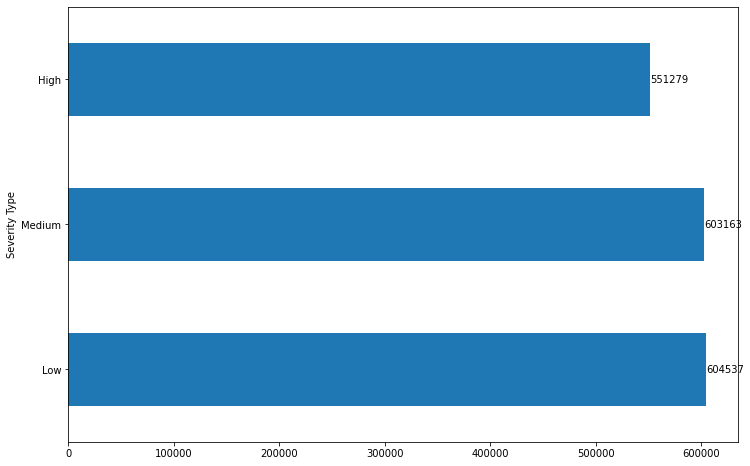

In [169]:
plots = df['pest_severity'].value_counts().plot(figsize=(12,8),kind='barh', xlabel='Severity Type')

for c in plots.containers:
    plots.bar_label(c)

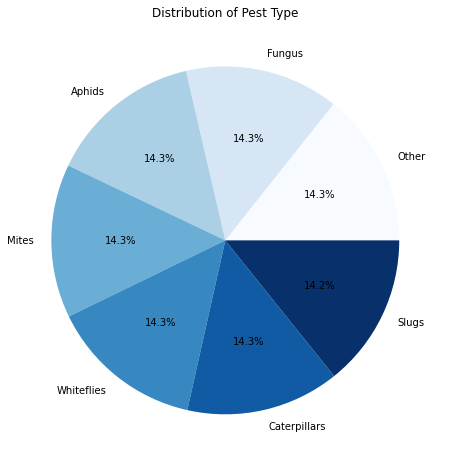

In [152]:
df['pest_type'].value_counts().plot(figsize=(12,8), kind='pie',autopct='%1.1f%%', ylabel='', 
                                    colormap='Blues', title='Distribution of Pest Type');

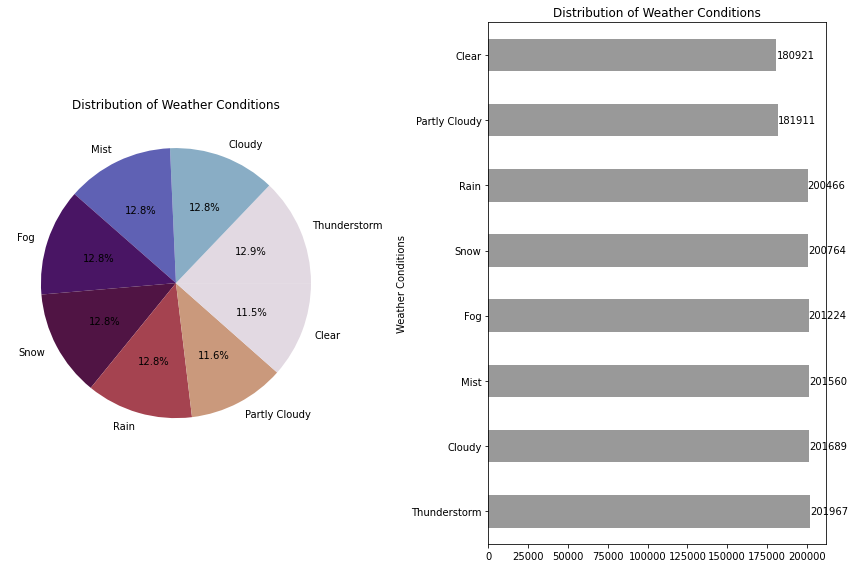

In [184]:
plt.subplot(1,2,1)
df['weather_condition'].value_counts().plot(figsize=(12,8), kind='pie',autopct='%1.1f%%', ylabel='', 
                                    colormap='twilight', title='Distribution of Weather Conditions')

plt.subplot(1,2,2)
plots = df['weather_condition'].value_counts().plot(figsize=(12,8), kind='barh', ylabel='Weather Conditions', 
                                    colormap='Set1_r', title='Distribution of Weather Conditions')

for c in plots.containers:
    plots.bar_label(c)

plt.tight_layout()

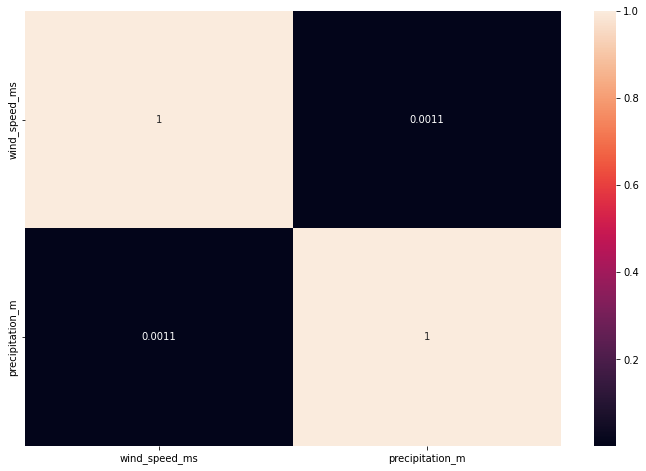

In [189]:
plt.figure(figsize=(12,8))
sns.heatmap(df[['wind_speed_ms','precipitation_m']].corr(), annot=True);

### No linear Correlation between wind speed and precipitation

# Feature Engineering

In [197]:
df.head()

,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition
timestamp,,,,,,,,,
2022-09-12 14:37:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0,0.31,0.01,WC-7,Snow
2022-09-12 14:37:00+00:00,Medium,NaN,P2,Caterpillars,2.0,7.29,0.01,NaN,NaN
2022-09-12 14:39:00+00:00,High,Whiteflies : presence detected.,P8,Whiteflies,3.0,9.61,0.25,WC-7,Snow
2022-09-12 14:40:00+00:00,NaN,Aphids : infestation found.,P1,Aphids,NaN,0.94,0.06,WC-8,Thunderstorm
2022-09-12 14:40:00+00:00,High,NaN,P8,Whiteflies,3.0,12.43,0.04,NaN,NaN


In [199]:
# Creating new features for Hour , Day and Month from the timestamp

df['hour'] = df.index.hour 
df['day'] = df.index.day
df['month'] = df.index.month
df['minute'] = df.index.minute

In [200]:
df.head()

,pest_severity,pest_description,pest_id,pest_type,pest_severity_encoded,wind_speed_ms,precipitation_m,weather_condition_id,weather_condition,hour,day,month
timestamp,,,,,,,,,,,,
2022-09-12 14:37:00+00:00,Low,Whiteflies : high infestation risk.,P8,Whiteflies,1.0,0.31,0.01,WC-7,Snow,14,12,9
2022-09-12 14:37:00+00:00,Medium,NaN,P2,Caterpillars,2.0,7.29,0.01,NaN,NaN,14,12,9
2022-09-12 14:39:00+00:00,High,Whiteflies : presence detected.,P8,Whiteflies,3.0,9.61,0.25,WC-7,Snow,14,12,9
2022-09-12 14:40:00+00:00,NaN,Aphids : infestation found.,P1,Aphids,NaN,0.94,0.06,WC-8,Thunderstorm,14,12,9
2022-09-12 14:40:00+00:00,High,NaN,P8,Whiteflies,3.0,12.43,0.04,NaN,NaN,14,12,9


In [201]:
df.drop(['pest_severity','pest_description','pest_id','pest_type','weather_condition_id'],axis=1, inplace=True)

**Pest type** was dropped because it showed even distribution across the classes and during the time of prediction in a real life scenario would not be an available input to make predictions

In [205]:
df.head()

,pest_severity_encoded,wind_speed_ms,precipitation_m,weather_condition,hour,day,month,minute
timestamp,,,,,,,,
2022-09-12 14:37:00+00:00,1.0,0.31,0.01,Snow,14,12,9,37
2022-09-12 14:37:00+00:00,2.0,7.29,0.01,NaN,14,12,9,37
2022-09-12 14:39:00+00:00,3.0,9.61,0.25,Snow,14,12,9,39
2022-09-12 14:40:00+00:00,NaN,0.94,0.06,Thunderstorm,14,12,9,40
2022-09-12 14:40:00+00:00,3.0,12.43,0.04,NaN,14,12,9,40


#### Dropping NaN values in the class to be predicted 'pest_severity_encoded'

In [209]:
df.dropna(subset='pest_severity_encoded',inplace=True)

In [210]:
df['weather_condition'].value_counts()

Thunderstorm     176531
Mist             175981
Cloudy           175931
Fog              175808
Snow             175307
Rain             175167
Partly Cloudy    158847
Clear            158261
Name: weather_condition, dtype: int64

one hot encoding the **weather condition** column

In [212]:
df = pd.get_dummies(df)

In [216]:
df['pest_severity_encoded'] = df['pest_severity_encoded'].astype('int64')

In [217]:
df

,pest_severity_encoded,wind_speed_ms,precipitation_m,hour,day,month,minute,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Fog,weather_condition_Mist,weather_condition_Partly Cloudy,weather_condition_Rain,weather_condition_Snow,weather_condition_Thunderstorm
timestamp,,,,,,,,,,,,,,,
2022-09-12 14:37:00+00:00,1,0.31,0.01,14,12,9,37,0,0,0,0,0,0,1,0
2022-09-12 14:37:00+00:00,2,7.29,0.01,14,12,9,37,0,0,0,0,0,0,0,0
2022-09-12 14:39:00+00:00,3,9.61,0.25,14,12,9,39,0,0,0,0,0,0,1,0
2022-09-12 14:40:00+00:00,3,12.43,0.04,14,12,9,40,0,0,0,0,0,0,0,0
2022-09-12 14:41:00+00:00,2,11.76,0.13,14,12,9,41,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-12 14:51:00+00:00,2,9.34,0.10,14,12,9,51,1,0,0,0,0,0,0,0
2023-09-12 14:51:00+00:00,2,9.92,0.04,14,12,9,51,0,0,0,0,1,0,0,0
2023-09-12 14:53:00+00:00,1,0.72,0.01,14,12,9,53,0,0,0,1,0,0,0,0


In [243]:
df.isnull().sum()

pest_severity_encoded              0
wind_speed_ms                      0
precipitation_m                    0
hour                               0
day                                0
month                              0
minute                             0
weather_condition_Clear            0
weather_condition_Cloudy           0
weather_condition_Fog              0
weather_condition_Mist             0
weather_condition_Partly Cloudy    0
weather_condition_Rain             0
weather_condition_Snow             0
weather_condition_Thunderstorm     0
dtype: int64

# Model Development

In [214]:
# splitting into Train and test data

In [219]:
train_df, test_df = train_test_split(df, test_size=0.33, stratify=df['pest_severity_encoded'], random_state=42)

In [267]:
sampled_df = train_df.sample(n=500000, random_state=42)

In [223]:
import xgboost as xgb
import numpy as np

In [235]:
y = train_df.pest_severity_encoded
X = train_df.drop('pest_severity_encoded', axis=1)

In [245]:
from sklearn.preprocessing import LabelEncoder

In [246]:
label_encoder = LabelEncoder()

In [247]:
y_encoded = label_encoder.fit_transform(y)

In [248]:
y_encoded

array([1, 0, 0, ..., 2, 0, 0], dtype=int64)

In [264]:
sampled_y = np.random.choice(y_encoded, size=500000, replace=False)

array([1, 1, 2, ..., 1, 2, 2], dtype=int64)

In [249]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',  
    num_class=len(np.unique(y)),  
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)

In [250]:
# using stratified K-fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [253]:
scores = cross_val_score(clf, X, y_encoded, cv=stratified_kfold, scoring='accuracy', verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.1min finished


In [254]:
# Evaluating the model
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Standard Deviation:", np.std(scores))

Cross-Validation Scores: [0.34318613 0.34355099 0.34354675 0.34370373 0.34484924]
Mean Accuracy: 0.34376736825581344
Standard Deviation: 0.0005670664704763204


In [289]:
clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

# Model Optimization & Hyperparameter Tuning;

In [269]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)

    return np.mean(cross_val_score(optuna_model, X, y, cv=stratified_kfold, scoring='accuracy'))


In [272]:
# using the downsampled train_df to carryout hyperparameter Tuning;

y = sampled_df.pest_severity_encoded
X = sampled_df.drop('pest_severity_encoded', axis=1)

y = label_encoder.fit_transform(y)

In [273]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2023-09-30 19:06:12,528] A new study created in memory with name: no-name-b0a61ed8-9911-4351-addd-e580ca6277c8
C:\Users\HP\python_folder\py310venv\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-09-30 20:11:03,582] Trial 0 finished with value: 0.341042 and parameters: {'max_depth': 9, 'learning_rate': 0.20615659855206644, 'n_estimators': 327, 'min_child_weight': 8, 'gamma': 7.798266095519085e-07, 'subsample': 0.08884084140010795, 'colsample_bytree': 0.13276204698292768, 'reg_alpha': 4.531933996839181e-08, 'reg_lambda': 0.5486040109432541}. Best is trial 0 with value: 0.341042.
[I 2023-09-30 20:18:53,125] Trial 1 finished with value: 0.33667800000000003 and parameters: {'max_depth': 6, 'learning_rate': 0.18916262019064645, 'n_estimators': 131, 'min_child_weight': 6, 'gamma': 0.0007327023760621738, 'subsample': 0.055878723170758794, 'colsample_bytree': 0.800648728250416, 'reg_alpha': 0.3372504689792159, 'reg_lambda': 0.001960758437292772}. Best is trial 0 with value: 0.341042.
[I 2023-09-30 20:29:09,398] Trial 2 finished with value: 0.342774 and parameters: {'max_depth': 8, 'learning_rate': 0.16204133729950443, 'n_estimators': 269, 'min_child_weight': 10, 'gamma': 8.8119

In [274]:
study.best_value

0.34496999999999994

In [275]:
study.best_params

{'max_depth': 1,
 'learning_rate': 0.011670042505282889,
 'n_estimators': 200,
 'min_child_weight': 1,
 'gamma': 0.007739076105781502,
 'subsample': 0.012002008995552187,
 'colsample_bytree': 0.04808560789997015,
 'reg_alpha': 1.4035694203448856e-06,
 'reg_lambda': 6.593522556539403e-08}

In [276]:
xgb_clf = xgb.XGBClassifier(**study.best_params)

In [283]:
xgb_clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.04808560789997015, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.007739076105781502, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.011670042505282889, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=1, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=1.4035694203448856e-06, ...)

# Model Evaluation

In [279]:
y_test = test_df['pest_severity_encoded']
x_test = test_df.drop('pest_severity_encoded',axis=1)

In [280]:
y_test = label_encoder.fit_transform(y_test)

In [290]:
predictions = clf.predict(x_test)

In [291]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.34      0.64      0.45    199498
           1       0.34      0.36      0.35    199044
           2       0.32      0.00      0.00    181922

    accuracy                           0.34    580464
   macro avg       0.34      0.33      0.27    580464
weighted avg       0.34      0.34      0.28    580464



### Plotting Feature Importance

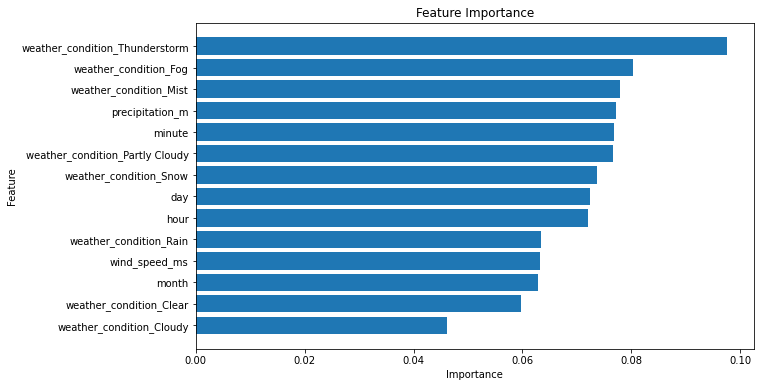

In [303]:
feature_importance = clf.feature_importances_
feature_names = X.columns  
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()

From the report above, the metrics indicates that we can't confidently predict future outbreaks given the environmental factors in the WEATHER table, as such we can't provide pre-emptive measures based off of the factors or variables considered during the development of the model.